In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dữ liệu từ file CSV
data = pd.read_csv('Data.csv')

# Chọn window và thuộc tính
window_size = 7
features = [ "Max Temp","Avg Temp" ,"Min Temp","Max Dew Point", "Avg Dew Point","Min Dew Point"]
target = 'Avg Temp'

# Chuẩn bị dữ liệu
x = data[features].values
y = data[target].values

# Chia thành train set và test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train, y_train = np.array(x_train), np.array(y_train)
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaler = scaler.fit(x_train)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [2]:
# Chuyển đổi dữ liệu thành các cửa sổ
trainX = []
trainY = []

for i in range(window_size, len(x_train)+1):
    trainX.append(x_train[i - window_size:i, :])
    trainY.append(x_train[i - 1:i,0])
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (698, 7, 6).
trainY shape == (698, 1).


In [3]:
testX = []
for i in range(window_size, len(x_test)+1):
    testX.append(x_test[i - window_size:i, :])
testX = np.array(testX)
testX = testX.reshape(testX.shape[0], -1)
print('testX shape == {}.'.format(testX.shape))

testX shape == (171, 42).


In [4]:
# # Xây dựng mô hình LSTM
# model_LSTM = Sequential()
# model_LSTM.add(LSTM(100, activation = 'relu', input_shape=(window_size, len(features))))
# model_LSTM.add(Dense(50, activation='relu'))
# model_LSTM.add(Dense(5, activation='relu'))
# model_LSTM.add(Dense(1))
from sklearn.svm import SVR
model_SVR = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
X = trainX.reshape(trainX.shape[0], -1)
print(X[0])

[0.27777778 0.21854305 0.45       0.         0.11682243 0.48387097
 0.38888889 0.29801325 0.4        0.14285714 0.20093458 0.48387097
 0.5        0.43046358 0.4        0.47619048 0.42990654 0.5483871
 0.55555556 0.52980132 0.55       0.66666667 0.53271028 0.58064516
 0.5        0.50331126 0.55       0.66666667 0.59813084 0.64516129
 0.5        0.54304636 0.55       0.57142857 0.55140187 0.64516129
 0.66666667 0.58278146 0.55       0.57142857 0.53738318 0.48387097]


In [5]:
# Compile và huấn luyện mô hình
# model.compile(loss='mae', optimizer = 'adam')
history = model_SVR.fit(X, trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
pred = model_SVR.predict(testX)
pred = pred.reshape(-1,1)

In [7]:
prediction_copies = np.repeat(pred, len(features), axis=-1)
predicted = scaler.inverse_transform(prediction_copies)[:,1]
print(scaler.inverse_transform(prediction_copies))

[[89.88817073 81.45618767 73.87574526 73.36953252 69.26704743 61.30740515]
 [90.7406858  82.17135309 74.82298422 74.36413343 70.28059312 62.77562554]
 [87.94808846 79.8286742  71.72009828 71.1061032  66.96050516 57.96615234]
 ...
 [92.18501858 83.38298781 76.42779842 76.04918835 71.99774431 65.26308756]
 [92.7593191  83.86476214 77.06591012 76.71920562 72.68052382 66.25216068]
 [92.59479296 83.72674298 76.88310329 76.52725845 72.48492051 65.96881009]]


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tính và hiển thị MAE
mae = mean_absolute_error(y_test[6:], predicted)
print("Mean Absolute Error (MAE):", mae)

# Tính và hiển thị MSE
mse = mean_squared_error(y_test[6:], predicted)
print("Mean Squared Error (MSE):", mse)

# Tính và hiển thị R2
r2=r2_score(y_test[6:], predicted)
print("R Square:", r2)

Mean Absolute Error (MAE): 1.228240477099447
Mean Squared Error (MSE): 2.2702322329963436
R Square: 0.7483669222915743


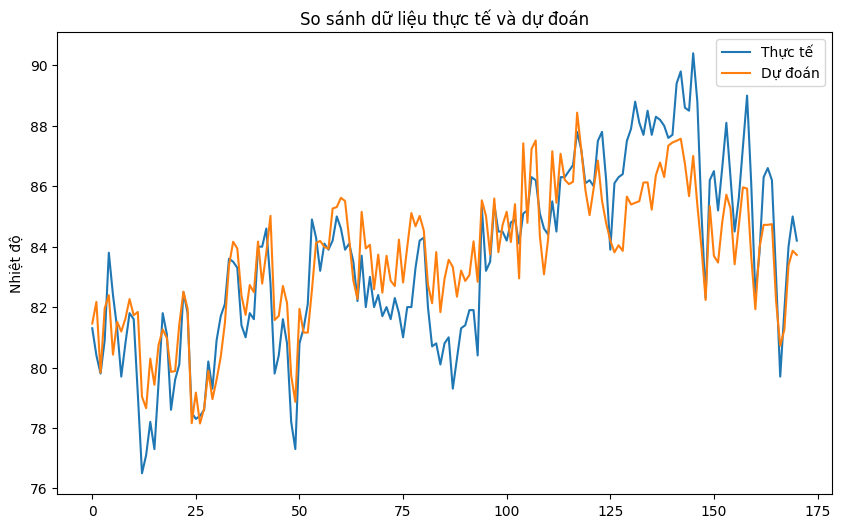

In [9]:
import matplotlib.pyplot as plt

# Tạo array index cho biểu đồ
index = range(len(pred))

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(index, y_test[6:], label='Thực tế')
plt.plot(index, predicted, label='Dự đoán')
plt.xlabel('')
plt.ylabel('Nhiệt độ')
plt.title('So sánh dữ liệu thực tế và dự đoán')
plt.legend()
plt.show()

In [10]:
n_days_for_prediction = 7
window_for_predict = testX[-1:]
predicted_future = []
for i in range (0,n_days_for_prediction):
  value_predicted = model_SVR.predict(window_for_predict)
  value_copy = np.repeat(value_predicted.reshape(-1,1), len(features), axis=-1)
  result_predicted = scaler.inverse_transform(value_copy)
  predicted_future = np.append(predicted_future,result_predicted[:,1], axis=0)
  window_for_predict = np.delete(window_for_predict, 0, axis=1)
  window_for_predict = np.reshape(np.append(window_for_predict,value_predicted), (1, 42))

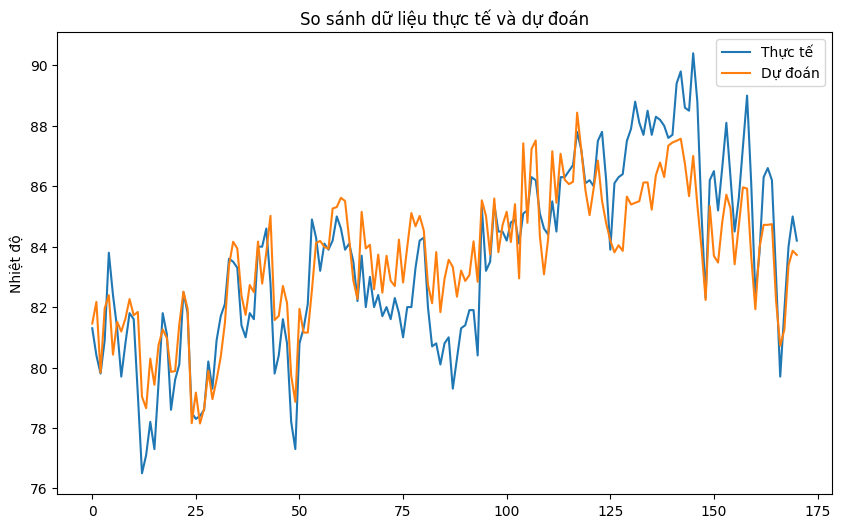

In [11]:
import matplotlib.pyplot as plt

# Tạo array index cho biểu đồ
index = range(len(pred))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(index, y_test[6:], label='Thực tế')
plt.plot(index, predicted, label='Dự đoán')
plt.xlabel('')
plt.ylabel('Nhiệt độ')
plt.title('So sánh dữ liệu thực tế và dự đoán')
plt.legend()
plt.show()

<ipython-input-17-58540608ac12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


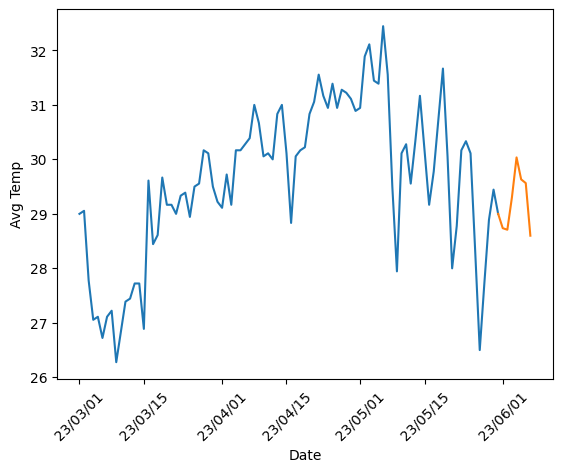

In [17]:
import seaborn as sns
import matplotlib.dates as mdates
original = data[['Date', 'Avg Temp']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-3-1']

forecast_period = pd.date_range(list(original['Date'])[-1], periods=n_days_for_prediction+1, freq='1d').tolist()

sns.lineplot(original, x = original['Date'], y = (original['Avg Temp']-32)*(5/9))
sns.lineplot(x = forecast_period, y = (np.insert(predicted_future, 0, y[-1:])-32)*(5/9))
# Định dạng lại nhãn trục x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))

# Hiển thị biểu đồ
plt.xticks(rotation=45)  # Để xoay nhãn trục x nếu cần

plt.show()